# Charting and Graphing

Collection of tools to create sailing charts, display race tracks, and plot instrument data versus time.

The first part of this notebook describes the the generation of GEO-registered charts, upon which lat/lon
positions can be scale accurately ploted.

The second describes the plotting of boat instrument data. 

We'll conclude with some details on how these two can be combined.

## Literate Notebook

Warning this is a [Literate Notebook](Literate_Notebook_Module.ipynb), i.e. the notebook contains the code for the charting module.  Do not edit the code in the module directly, edit the notebook and then regenerate the module code.

    convert_notebook.py Chart_Module.ipynb --module

In [1]:
# notebook - let's start out with the goal in mind, and then work backwards

def create_and_display_chart(race_data):
    "Load race data and then create a chart and draw the race track."
    chart = plot_chart(race_data)
    return chart

def plot_instrument_data_from_race():
    "Load a race and plot several instruments on the same graph"
    df = example_race()
    plot = quick_plot(df.row_times, "df.spd df.sog df.tws")
    return plot

## Background

Charting is critical to understanding the data collected during a race.  Data about SPD or AWA is disembodied without some sort of geographical reference.

We think about physical space and situations, so we often as questions like "did we pinch before the windward mark?" or "did we sail too far before jibing to the leeward mark?".  These questions are tough to ask when only looking at graphs of heading and speed.  Knowing where we were and when is critical.


![im](Data/Images/chart_chart_with_track.png)

Key properties of a chart:

- Accuracy: it should be based on accurate nautical data. Depths. Buoys. Etc.
- Geolocation: the chart is an image which is measured in pixels, the race track is measured in GPS lat/lon.  We need to accurately place the track on the chart.  An image where the mapping from pixel coordinates to lat/lon is "geolocated".
- Calibration: the map should be in familiar units, so that we can graph velocities in natural ways.  We use meters.

After exploring many options, we converged on a NOAA charts (no surprise).  NOAA has a confusingly large number of chart options, including Raster Navigational Charts (RNC), Electronic Navigational Charts (ENC), and PDFs of the old paper charts.  To be honest, I'd use the PDFs if not for two problems:  i) the charts have annoying boundaries which are crossed by many races, and ii) the PDFs can be geolocated, but it is not trivial.  RNC files are geolocated, but they are in some sort of weird bespoke image format.  ENC is a vector based representation containing coastlines, buoys, and other navigational features as lat/lon coordinates.  ENCs are not images, and rendering ENCs to images is tricky, though it provides huge flexibility since you need not render any particular type of feature can be included, or removed.

I have chosen to use the [NOAA tile representation](https://tileservice.charts.noaa.gov/tileset.html#50000_1-locator).

### Additional Links

- A web views for the NOAA tiles: [LINK](https://tileservice.charts.noaa.gov/tiles/50000_1/viewer-openlayers.html).
- [NOAA Chart Navigator](https://www.charts.noaa.gov/InteractiveCatalog/nrnc.shtml): a map based navigator that will show you all the available charts.
- [RNC vs ENC](https://nauticalcharts.noaa.gov/charts/rnc-and-enc-comparison.html): compare and contrast of RNC and ENC.  We use neither, though both would likely work with work.
- [Chart Booklets](https://www.charts.noaa.gov/BookletChart/18449_BookletChart.pdf): a PDF booklet of small chart images at high resolution.  An area is divided into 18 pages, each on a different page.  Great for printing.  These are really cool and what I would use if I were using paper charts on my boat.

### And more links

- [mapzen](https://www.mapzen.com/) Pretty interesting high performance mapping.

### What is a tiled representation?

Mapping web sites (like Google maps) use tile servers (more here [Wikipedia](https://en.wikipedia.org/wiki/Tiled_web_map)).  Also see this very cool [site](https://mc.bbbike.org/mc/?lon=-122.436&lat=47.661&zoom=14&num=4&mt0=mapnik&mt1=esri) that will allow you to compare **many** tiled maps (though it does **not** include NOAA charts, or any useful marine charts).

NOAA tiled maps are great because they have stitched together every NOAA chart into a single world map (so we have no awkward chart boundaries).  Because these are actually mashups of the existing charts, the map is weird in the corners and away from the water.  You can see bits and pieces of different charts.  Luckily, the quality is high and consistent in the navigable waters.

Large scale: a very odd looking (hand drawn?) map.  This is not useful!
![im](Data/Images/chart_tile_big.png)

Middle scale starts to look like a chart.
![im](Data/Images/chart_tile_mid.png)

You can keep drilling down to the finer scales (it stops where the highest resolution NOAA charts stop).
![im](Data/Images/chart_tile_small.png)

The beauty of using a tile server is that you can pull down just the tiles you need at the resolution you need (its never more than about 100 tiles).  For a while I considered using these services directly (like your web browser does when using google maps).  There are two issues.  1) Figuring out what tiles to load.  2) Remapping them them to a reasonable projection.

Rather than query a web server to create every chart, we took an offline approach instead.

1. Download a large MBTILES file that contans all the tiles for a region.
  - MBTILES, defined by MapBox [spec](https://github.com/mapbox/mbtiles-spec), is an SQLite file containing all the tiles.
  - The Pacific Northwest is MBTILES_06.  California is MBTILES_10.  Files are in `Data/MBTILES`
  - Each of the files is very large, 500 Meg.
2. From the MBTILES one can create a basemap that is very high res, that is focused on the sailable area in a region.
  - Seattle map is 10,000 by 30,000 image.  130 Meg compressed TIF.
  - This file is smaller than the MBTILES file, but not by a lot
3. Either from MBTILES or basemap, extract the chart of interest that covers the extent of the race.
4. To draw on this map, convert lat/lon into chart coordinates.

Here is a quick link to a world map of MBTILE files [LINK](https://github.com/vokkim/noaa-nautical-charts) with helpful links to the actual files.

![im](Data/Images/chart_mbtiles_map.png)

And here is a low resolution version of a "basemap" for the Puget Sound.  Notice it does *NOT* include the San Juan Islands, it was purposely cropped to the Puget Sound south of Port Townsend.  This keeps it down to a manageable size.  The blank areas are not part of the NOAA charts, and are left undefined (a fancier approach would backfill these areas from another tile server... we don't care).

![im](Data/Images/chart_basemap.jpg)

Both the MBTILES file and the basemap are georegistered files.  They include metadata that describes the map projection, the geographic extent, and the scale.

Why do it this way?  Couple of reasons.

- Its faster than querying the web service, can run without an internet connection, and is perhaps more reliable.
- We can use an extremely powerful tool called [GDAL](https://gdal.org/) to process the MBTILE to extract charts with arbitrary boundaries and scales, and convert to a local map projection that makes sense.
- GDAL has python bindings, so we can use the same code to convert lat/lon to map coordinates.

GDAL is the swiss army knife of GIS data.  In particular it is really good at dealing with reprojecting the data from one map projection to another (there are 100's of projections, [great site on projections](https://www.arcgis.com/apps/MapJournal/index.html?appid=31484c80dba54a058369dfb8e9ced549)).  GDAL is also very complex.  To get started, I recommend a set of introductory articles [A Gentle Introduction to GDAL](https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-1-a3253eb96082).

### Spatial Reference Systems (SRS)

[Wikipedia](https://en.wikipedia.org/wiki/Spatial_reference_system)

In order to get GDAL to do its thing, you need to specify the various coordinate systems used in the map, etc.  This "spatial reference system" essentially defines the 3D position of any point on the map.  Converting between maps (with differnet SRS's) is then "just math".

There are three coordinate systems of interest:

1. The reference system of the MBTILES file. Luckily GDAL knows how to extract that information and silently and magically use it.
  - The NOAA tiles are in "[web mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection)".  [Mercator](https://en.wikipedia.org/wiki/Mercator_projection), as we learned in school stretches distance as you get near the poles.  And the "web" part introduces other inaccuracies for the sake of efficiency in browsers.
2. The reference system of the charts we will generate.  Since web mercator is inaccurate, we use [transverse mercator](https://en.wikipedia.org/wiki/Transverse_Mercator_projection) centered near our region (which reduces distortion to less than a meter).
3. The reference system for the GPS lat/lon measurements.  This is called WGS84.

Note, there are several standard ways to specify SRS:

- [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset).  This is a handy, huge table of standardized SRS's.
  - Web mercator is : [EPSG:3857](https://epsg.io/3857)
  - GPS coordinates: [EPSG:4326](https://epsg.io/4326)
  - There is none for our bespoke transverse mercator.
- [Proj4](https://proj.org/index.html):  *PROJ is a generic coordinate transformation software that transforms geospatial coordinates from one spatial reference system to another.*.  Proj provides a standard language for specifying SRS.
  - Web mercator: `+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs`
  - WGS84: `+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs `
  - Transverse mercator centered in Seattle: `+proj=tmerc +lat_0=47.6873070 +lon_0=-122.4386440 +k_0=0.9996 +datum=WGS84 +units=m +no_defs`

And there are others.  GDAL is the master of them all!  Below is the dump using `gdalinfo` on the MBTILES file.

```
> gdalinfo MBTILES_06.mbtiles
Driver: MBTiles/MBTiles
Files: MBTILES_06.mbtiles
Size is 12582912, 4456448
Coordinate System is:
PROJCS["WGS 84 / Pseudo-Mercator",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Mercator_1SP"],
    PARAMETER["central_meridian",0],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["X",EAST],
    AXIS["Y",NORTH],
    EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs"],
    AUTHORITY["EPSG","3857"]]
```

## Map projections (very optional)

The whole field of Geographic Information Systems (GIS) is pretty deep.  For example, what exactly is a DATUM?  How do you measure sea level?  How do you do it in Kansas, far from any ocean?  Is the globe a sphere, an ellipsoid, or some other strange shape?

The reality is that most of the complexity comes from the fact that we've been building maps, and navigating for a very long time.  There are some awesome Web resources, where you can get lost for many hours (days).

- [Measuring the Height of Mt. Everest](https://en.wikipedia.org/wiki/Great_Trigonometrical_Survey)
- [US National Geodetic Survey](https://en.wikipedia.org/wiki/U.S._National_Geodetic_Survey).  Just keep reading and clicking.

GPS really simplified things.  Where before you needed to using surveying equipment to measure the relative position of landmarks (in some cases over 1000's of miles), now one just uses GPS.  While handheld GPS is accurate to a few meters, by recording data over hours it can be accurate to inches.  Lot's of great info here: [GPS.gov](https://www.gps.gov/systems/gps/performance/accuracy/).

GPS reports information in [WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System) which uses an ellipsoidal model of the earth's surface.  Maps, some of which were created many years ago, are a projection from a coordinate system used at the time (DATUM) to a flat piece of paper.  The map maker, and map users, want their map to have high accuracy for measuring distances and directions (like the direction of true north).  And you should be able to read off the lat/lon and use it to report locations, etc.

But because there are maps made in many countries, for many reasons, and at many times in the past, GIS and GDAL needs to handle the various complex ways reference systems.

For us GDAL handles two tricky tasks: i) creating a map which is geo-referenced, and ii) projecting lat/lon track points into the coordinates of the image.

Note, I feel the whole field could benefit if you "forgot" all the niggling details from the past.

## Tile Servers

As often happens, as I write I begin to understand better.  Writing a section naturally raises questions in my mind, and as I try to provide a link or reference I find additional info.  It happened again, as I wrote the section on tiled map servers.  To the rescue came the Open Street Map (OSM) page on [Slippy Maps](https://wiki.openstreetmap.org/wiki/Slippy_Map) (their funky name for tiled maps).  Additional details on referencing tiles is [here](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames).

For completeness, I'll include code to fetch maps from the NOAA server on demand.  This "on demand" code could work better if you do not know in advance where you'll be sailing, or if the disk space to store the MBTILES files is not available.

In [2]:
%matplotlib widget

In [3]:
# Load some libraries

# Basics
import os
import math
import time  # used to compute elapsed times
# Helpful when plotting dates.
from datetime import datetime
from dateutil import tz

# Matplotlib is the engine for plotting graphs and images
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
import matplotlib.style as mplstyle
# Try to make matplotlib faster.  See https://matplotlib.org/tutorials/introductory/usage.html#performance
mplstyle.use('fast')

# Numpy and Pandas are used to process our racing data.
import numpy as np
import pandas as pd

# OpenCV is a powerful tool for image manipulation.
import cv2  # why is it called cv2?  ... just is.

# These are libraries written for RegattaAnalysis
from global_variables import G  # global variables
from utils import DictClass, is_iterable
import utils

In [4]:
# notebook - initial setup

import itertools as it

# These are libraries written for RegattaAnalysis
import race_logs                # load data from races
import nbutils
from nbutils import display_markdown, display

# Initialize for Seattle.
G.init_seattle(logging_level="INFO")

In [4]:
# Helper functions

def new_axis(fignum=None, equal=False, clf=True):
    "Convenience to create an axis with optional CLF and EQUAL."
    fig = plt.figure(fignum)
    if clf:
        fig.clf()
    ax = fig.add_subplot(111)
    if equal:
        ax.axis('equal')
    return fig, ax

In [5]:
# notebook - in order to exercise charting code, we'll need to load a race

def example_race(date="2019-11-16"):
    dfs, races, big_df = race_logs.read_dates([date], race_trim=False)
    display(races)
    return dfs[0]

df = example_race()
# df = example_race("2020-05-31")

2022-06-30 11:26:21,844|INFO|read_metadata| Read 193 records.
2022-06-30 11:26:21,845|INFO|read_logs| Reading file 2019-11-16_10:09.pd.gz
2022-06-30 11:26:22,428|INFO|read_log_file| Session from 2019-11-16 18:09:15.020000, 128865 rows, 3.5797222222222222 hours.
2022-06-30 11:26:24,086|INFO|read_logs| Found 126190 records before trim.


[{'file': '2019-11-16_10:09.pd.gz',
  'date': '2019-11-16',
  'title': 'Snowbird #1',
  'begin': 41076,
  'end': 111668,
  'source': 'loginfo',
  'description': 'Snowbird #1.'}]

In [6]:
# notebook
display_markdown(f"### Some global constants related to chart preparation")

display_markdown("For any region, we first determine the center of the sailing area.")
display_markdown(f"For {G.LOCALE} the center is **lat**: {G.LATITUDE_CENTER} **lon:** {G.LONGITUDE_CENTER}")

display_markdown("The Seattle local spatial reference system in Proj format")
display(G.PROJ4)

display_markdown("Path to the MBTILES file:")
display(G.MBTILES_PATH)

# In additon there is a direct python binding of GDAL that is available through pyproj
import pyproj
gmap = pyproj.Proj(G.PROJ4)

space_needle = (-122.349254, 47.620367)  # (lon, lat) for GDAL and pyproj

west, north = gmap(*space_needle)
display_markdown(f"The space needle is {west:.0f} meters east and {north:.0f} meters north of the center.")

display_markdown("We can also efficiently bulk convert lat/lon to meters. And then plot:")
df_west, df_north = gmap(np.array(df.longitude), np.array(df.latitude))

# Matplotlib defaults to scaling each axis independently.  This fixes that.
fig, ax = new_axis(equal=True)
ax.plot(df_west, df_north)
ax.set_title("Postion in meters from 'center of sailing area'")

### Some global constants related to chart preparation

For any region, we first determine the center of the sailing area.

For Seattle the center is **lat**: 47.687307 **lon:** -122.438644

The Seattle local spatial reference system in Proj format

' +proj=tmerc +lat_0=47.6873070 +lon_0=-122.4386440 +k_0=0.9996 +datum=WGS84 +units=m +no_defs '

Path to the MBTILES file:

'Data/MBTILES/MBTILES_06.mbtiles'

The space needle is 6717 meters east and -7436 meters north of the center.

We can also efficiently bulk convert lat/lon to meters. And then plot:

<IPython.core.display.Javascript object>

Text(0.5, 1.0, "Postion in meters from 'center of sailing area'")

## GDAL: gdalwarp

(I explored using the `pyproj` GDAL bindings to do this. The command line program `gdalwarp` ended up working well.  Long term should reinvestigate using pyproj directly.)

Documentation from [gdalwarp](https://gdal.org/programs/gdalwarp.html) 

> The gdalwarp utility is an image mosaicing, reprojection and warping utility. The program can reproject to any supported projection, and can also apply GCPs stored with the image if the image is “raw” with control information.

`-t_srs <srs_def>`  Set target spatial reference.  *We use Proj4.*

`-te <xmin ymin xmax ymax>`  Set georeferenced extents of output file to be created.  *We use the lat/lon boundaries.*

`-te_srs <srs_def>` Specifies the SRS in which to interpret the coordinates given with -te. *We use lat/lon in WGS 84, aka GPS.*

`-ts <width> <height>` Set output file size in pixels and lines. If width or height is set to 0, the other dimension will be guessed from the computed resolution.

`-oo <NAME=VALUE>`  Dataset open option (format specific).  *We use this to specify the zoom level of the MBTILES file.*

### Lat/Lon vs Lon/Lat

A bit of an aside on lat/lon versus lon/lat.  I am prefer lat/lon.  GDAL uses lon/lat.
Its a bug waiting to happen. We'll use named fields in a dict where we can.  And then
only access GDAL through functions.  This should limit the risk.

BTW, why dicts rather than classes?  Well classes are heavyweight and they clutter up my
code.  It's actually work to get Python classes to do a lot more than dicts (for
example, you can incorrectly set fields, etc).  I do like field access in classes much
better: `foobar.field` is much better than `foobar['field']` (the second hurts my hands).

The utils module has a cute hack called DictClass.  It's a class, but it behaves a lot
like a dict.  We'll generally use DictClass.


In [7]:
# This is the heart of the chart extraction process.

def gdal_extract_chart(chart, source_path, chart_path, zoom_level=None):
    """
    Using GDAL, extract a chart from the source image.

    chart                  : a dict with lat_max, lat_min, lon_max, lon_min, for the extent of the map
    source_path, chart_path : path of the input and output files
    zoom_level              : optional, specify to limit resolution and speed up (13 will do that)
    pixels                  : max width/height of the image, other dimension is computed from extent
    srs                     : spatial reference of the resulting chart
    """
    # Find the extents of the map

    sw = map_project(DictClass(lat=chart.lat_min, lon=chart.lon_min))  # Southwest corner
    ne = map_project(DictClass(lat=chart.lat_max, lon=chart.lon_max))  # Northeast corner

    south, west = sw.north, sw.east
    north, east = ne.north, ne.east

    # Setup gdalwarp args
    # Define the extent of the chart in lon/lat
    te = f"-te {chart.lon_min:.7f} {chart.lat_min:.7f} {chart.lon_max:.7f} {chart.lat_max:.7f}"
    # Reference system of the extent
    te_srs = " -te_srs EPSG:4326 "  # WGS 84

    # Define the SRS of the result
    t_srs = f"-t_srs '{chart.proj}'"
    # Size the image to the longest axis,
    if (east - west) > (north - south):  # wide?
        ts = f"-ts {chart.pixels} 0"  # limit width
    else:
        ts = f"-ts 0 {chart.pixels}"   # limit height

    # Note the default is to pick the zoom level that is matched to the output resolution.
    # Smaller numbers are lower res, and faster.  13 will speed things up a bit.
    if zoom_level is None:
        zoom = ""
    else:
        zoom = f"-oo ZOOM_LEVEL={zoom_level}"  # A hint to determine the level of the pyramid to use.

    command = f"gdalwarp {zoom} {te} {te_srs} {t_srs} {ts} -r bilinear {source_path} {chart_path}"

    run_system_command(f"rm {chart_path}")  # remove output, since gdalwarp will not overwrite
    run_system_command(command)
    # Add the extent of the map in the projection
    return chart.union(dict(south=south, north=north, east=east, west=west,
                            path=chart_path, source=source_path))


def run_system_command(command, dry_run=False):
    "Run a shell command, time it, and log."
    G.logger.debug(f"Running command: {command}")
    if not dry_run:
        start = time.perf_counter()
        os.system(command)
        end = time.perf_counter()
        G.logger.debug(f"Command finished in {end-start:.3f} seconds.")

def map_project(p):
    """
    Project lat/lon pair into our prefered map projection.
    """
    east, north = G.MAP(p.lon, p.lat)  # gdal order is lon then lat, I prefer lat/lon
    return DictClass(north=north, east=east)

def region_from_marks(latlon_list, lat_border=0.2, lon_border=0.3):
    "Compute a map region from a set of latlon marks."
    lats = [p.lat for p in latlon_list]
    lons = [p.lon for p in latlon_list]    
    lat_max, lat_min = max_min_with_border(np.array(lats), lat_border)
    lon_max, lon_min = max_min_with_border(np.array(lons), lon_border)
    return DictClass(lat_max=lat_max, lat_min=lat_min,
                     lon_max=lon_max, lon_min=lon_min)

def extract_region(df, border=0.2, fudge = (0.015, -0.015)):
    """
    Extract the geographic region which covers the entire race track.  BORDER is an
    additional margin which ensures you do not bump up against the edge when graphing.
    """
    # Add just a bit of "fudge factor" to ensure that the extent is not too small, which
    # triggers some corner cases.

    # TODO: since the border is applied in lat/lon separately, its is not uniform.  Same
    # for FUDGE.
    lat_max, lat_min = max_min_with_border(df.latitude, border) + fudge
    lon_max, lon_min = max_min_with_border(df.longitude, border) + fudge

    return DictClass(lat_max=lat_max, lat_min=lat_min,
                     lon_max=lon_max, lon_min=lon_min)


def max_min_with_border(values, border=0.1):
    "Return the range of a series, with a buffer added which is border times the range."
    max = values.max()
    min = values.min()
    delta = (max - min)
    max = max + border * delta
    min = min - border * delta
    return np.array((max, min))


In [8]:
# notebook - on performance

# I started out thinking that extracting a basemap would make things go faster, but I
# eventually realized the speed difference was due to the resolution of the data being
# extracted.  The basemap is at level 14, which is a bit high for many of our races.

# Currently extracting the "correct" resolution image directly from MBTILES files is
# faster!  The main reason is that MBTILES contains all the resolutions, including the
# lower res images.  Its faster to convert the lower res images.

# Adding a border helps give context.

G.set_logging_level("DEBUG")

region = extract_region(df, 0.2)
display(region)

# Setup for rendering a chart
chart = region.union(dict(border=0.2, pixels=2000, proj=G.PROJ4))

# Extract from the basemap
chart = gdal_extract_chart(chart, G.BASE_MAP_PATH, '/tmp/base.tif')

# Extract directly from MBTILES
chart = gdal_extract_chart(chart, G.MBTILES_PATH, '/tmp/mbtile.tif')
display(chart)

# Note, for this test the time is close to identical (and very fast).  For larger extents,
# MBTILES can be faster.

{'lat_max': 47.76891304,
 'lat_min': 47.642535360000004,
 'lon_max': -122.35657114,
 'lon_min': -122.45864216}

2021-02-21 20:43:22,529|DEBUG|run_system_command| Running command: rm /tmp/base.tif
2021-02-21 20:43:22,534|DEBUG|run_system_command| Command finished in 0.004 seconds.
2021-02-21 20:43:22,534|DEBUG|run_system_command| Running command: gdalwarp  -te -122.4586422 47.6425354 -122.3565711 47.7689130  -te_srs EPSG:4326  -t_srs ' +proj=tmerc +lat_0=47.6873070 +lon_0=-122.4386440 +k_0=0.9996 +datum=WGS84 +units=m +no_defs ' -ts 0 2000 -r bilinear Data/maps/seattle_base_map.tif /tmp/base.tif
2021-02-21 20:43:23,031|DEBUG|run_system_command| Command finished in 0.496 seconds.
2021-02-21 20:43:23,031|DEBUG|run_system_command| Running command: rm /tmp/mbtile.tif
2021-02-21 20:43:23,037|DEBUG|run_system_command| Command finished in 0.005 seconds.
2021-02-21 20:43:23,037|DEBUG|run_system_command| Running command: gdalwarp  -te -122.4586422 47.6425354 -122.3565711 47.7689130  -te_srs EPSG:4326  -t_srs ' +proj=tmerc +lat_0=47.6873070 +lon_0=-122.4386440 +k_0=0.9996 +datum=WGS84 +units=m +no_defs ' -

{'lat_max': 47.76891304,
 'lat_min': 47.642535360000004,
 'lon_max': -122.35657114,
 'lon_min': -122.45864216,
 'border': 0.2,
 'pixels': 2000,
 'proj': ' +proj=tmerc +lat_0=47.6873070 +lon_0=-122.4386440 +k_0=0.9996 +datum=WGS84 +units=m +no_defs ',
 'south': -4975.69625650294,
 'north': 9073.001994807792,
 'east': 6149.557132226704,
 'west': -1502.0489317048775,
 'path': '/tmp/mbtile.tif',
 'source': 'Data/MBTILES/MBTILES_06.mbtiles'}

### Basemap is not a clear winner.

Glancing though the log output above, for this chart extracting directly from the full resolution MBtiles is actually a bit faster (it actually varies from chart to chart based on size).  

The huge advantage is that you need not prepare a basemap (no pre-selecting a resolution or region).

<IPython.core.display.Javascript object>


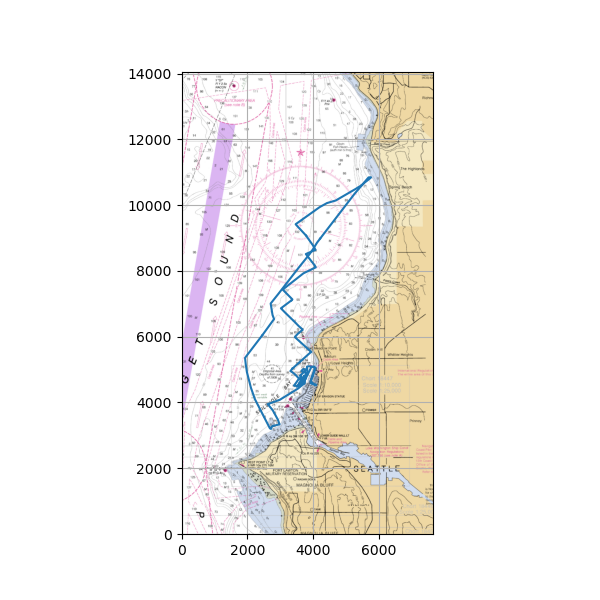

In [9]:
# notebook  - read the resulting image and display

image = cv2.imread(chart.path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = new_axis()

# By specifying the extent, matplot "knows" the scale of the image.  Note, extent is
# weird: (left, right, bottom, top) Let's set the image coordinates to start 0,0 at the
# lower left.
ax.imshow(image, extent=[0, chart.east - chart.west, 0, chart.north - chart.south])
ax.grid(True)
# We can plot the projected coordinates directly on the image.
ax.plot(df_west - chart.west, df_north - chart.south)


### Perfect, almost

First take a moment to zoom in to the marina.  Keep drilling down until you can see the separate docks.  You can clearly see that we are at our dock in our slip, and that we back up to depart.

This is close to perfect alignment.  Success.

The overlayed track and the graph can be hard to see at points, particularly when zoomed in.  The issue is that the chart image uses bright and saturated colors, just as the track does.

We can desaturate the image as follows:

In [10]:
def desaturate_image(im, factor=2):
    "Desaturate the colors in an image, in preparation for plotting on that image."
    hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)  # HSV is hue, saturation, value (intensity)
    hsv[:, :, 1] = hsv[:, :, 1] // factor      # divide the value by factor
    val_offset = ((factor - 1) * 255) // factor
    hsv[:, :, 2] = val_offset + (hsv[:, :, 2] // factor)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

<IPython.core.display.Javascript object>


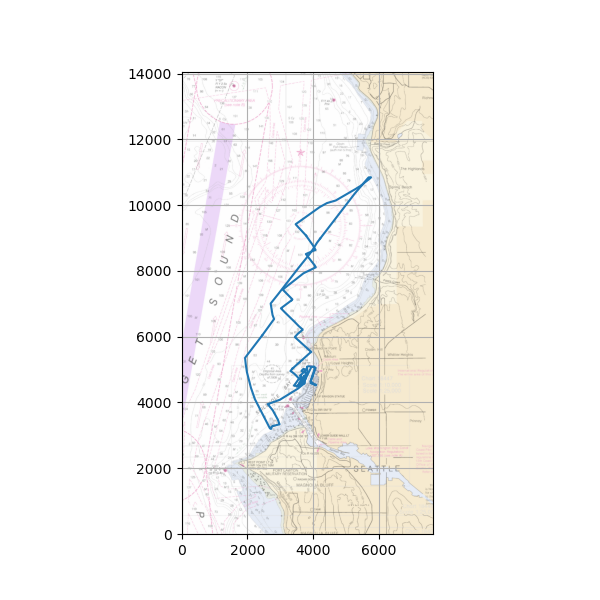

In [11]:
# notebook - use desaturated charts

fig, ax = new_axis()

ax.imshow(desaturate_image(image), extent=[0, chart.east - chart.west, 0, chart.north - chart.south])
ax.grid(True)
ax.plot(df_west - chart.west, df_north - chart.south)

In [12]:
# Combining all features.

def plot_chart(df, fig=None, border=0.2, pixels=2000, color='green', fudge=(0.015, -0.015),  **plot_args):
    """
    Plot a track for race.  The background chart comes from NOAA tiled charts.
    """
    region = extract_region(df, border, fudge=fudge) 
    chart = create_chart(region, pixels=pixels)
    chart.fig, chart.ax = create_figure(fig)
    chart = draw_chart(chart, chart.ax)
    chart = draw_track(df, chart, color=color, **plot_args)
    return chart

def create_chart(region, pixels=2000):
    """
    Using the extent of the GPS race track, create a geolocated map image AND a
    reprojection of the track into the local north/east coordinates.

    Data is loaded into a 'chart' dict, which will collect info on this transformation and
    later plots.
    """
    # Extract the region of the race.
    chart = region.union(dict(proj=G.PROJ4, pixels=pixels))
    
    chart = gdal_extract_chart(chart, G.MBTILES_PATH, "/tmp/mbtile.tif")
    image = cv2.imread(chart.path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return chart.union(dict(image=image))

def create_figure(fig=None, figsize=(6, 6)):
    G.logger.debug(f"Creating figure {fig}")
    if isinstance(fig, matplotlib.figure.Figure):
        fig = fig
    else:
        fig = plt.figure(num=fig, figsize=figsize)
    fig.clf()
    ax = fig.add_subplot(111)   
    return fig, ax

def draw_chart(chart, ax=None, desaturate=True):
    if ax is None:
        ax = chart.ax
    if desaturate:
        image = desaturate_image(chart.image)
    else:
        image = chart.image
    ax.imshow(image, 
              extent=[chart.west, chart.east, chart.south, chart.north])
    ax.grid(True)
    return chart

def draw_track(df, chart, ax=None, color='green', **plot_args):
    """
    Convert the track from lat/lon to image coordinates and then draw.

    Optionally draw on a specific axis.
    """
    lon, lat = np.asarray(df.longitude), np.asarray(df.latitude)
    track = np.vstack(G.MAP(lon, lat)).T
    chart.track = track
    if ax is None:
        ax = chart.ax
    chart.line = ax.plot(chart.track[:, 0], chart.track[:, 1], color=color, **plot_args)[0]
    return chart

2021-02-21 20:43:23,643|DEBUG|run_system_command| Running command: rm /tmp/mbtile.tif
2021-02-21 20:43:23,648|DEBUG|run_system_command| Command finished in 0.005 seconds.
2021-02-21 20:43:23,648|DEBUG|run_system_command| Running command: gdalwarp  -te -122.4586422 47.6425354 -122.3565711 47.7689130  -te_srs EPSG:4326  -t_srs ' +proj=tmerc +lat_0=47.6873070 +lon_0=-122.4386440 +k_0=0.9996 +datum=WGS84 +units=m +no_defs ' -ts 0 2000 -r bilinear Data/MBTILES/MBTILES_06.mbtiles /tmp/mbtile.tif
2021-02-21 20:43:24,042|DEBUG|run_system_command| Command finished in 0.394 seconds.
2021-02-21 20:43:24,106|DEBUG|create_figure| Creating figure None


<IPython.core.display.Javascript object>


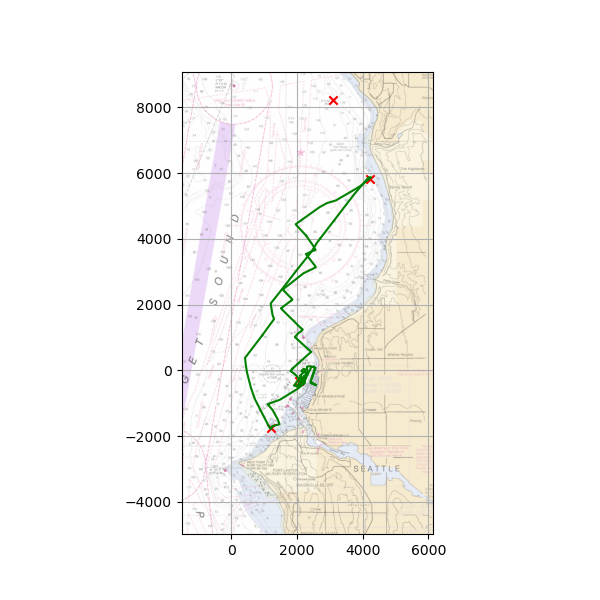

In [13]:
# notebook - demonstrate that it works.

ch = create_and_display_chart(df)

## Adding race marks

Returning to our original goal, we would like to understand boat performance at various points in the race.

The graph above is from a race with a south wind, starting in front of the marina N, heading south to the B, and then north to R, and finally back to N.  Below are the mark descriptions from the Sloop Tavern Yacht Club [Race Book](https://www.styc.org/race_info/RaceBook/2020/2020.pdf) page 11.

- N Round metal ball with flag located near the North end of Shilshole Breakwater (47° 41.064,
  122 24.679), in 87 feet of water. This is the near old North Hamburger location.
  O Temporary mark located North of Point Monroe, in approx. 90 feet of water (47° 42.600, 122 30.450).
  
- B Ballard Sails Buoy, a 3.5-ft. high White Buoy located Southwest of the Ship Canal entrance,
  near the shore at Discovery Park (47° 40.285, 122°25.342). This is the old South Hamburger
  location.

- R Spring Beach: A 3.5-ft. high White Buoy located in 40 ft. of water in the vicinity of Spring
  Beach, approximately 2 nm N of Meadow Pt. (47° 44.387, 122 ° 22.944 W). A railroad block
  signal is located at Spring Beach.


In [14]:
# notebook - graph the mark locations on the race track

from latlonalt import LatLonAlt as lla

styc_race_marks = dict(
    n_mark = lla.from_degrees_minutes((47, 41.064), (-122, 24.679)),
    b_mark = lla.from_degrees_minutes((47, 40.285), (-122, 25.342)),
    r_mark = lla.from_degrees_minutes((47, 44.387), (-122, 22.944)),
    u_mark = lla.from_degrees_minutes((47, 45.676), (-122, 23.833))
)

for key, val in styc_race_marks.items():
    display_markdown(f"The decimal degrees position of {key}: {val}")

lon = np.array([m.lon for m in styc_race_marks.values()])
lat = np.array([m.lat for m in styc_race_marks.values()])

# much like the code above to compute the track
marks = np.vstack(G.MAP(lon, lat)).T 

# Add red x's to the chart ABOVE, at the location of the marks
ch.ax.scatter(marks[:, 0], marks[:, 1], color='red', marker='x')
              
display_markdown("**Be sure to look at the chart above for the marks!**")

The decimal degrees position of n_mark: 47.684400N 122.411317W

The decimal degrees position of b_mark: 47.671417N 122.422367W

The decimal degrees position of r_mark: 47.739783N 122.382400W

The decimal degrees position of u_mark: 47.761267N 122.397217W

**Be sure to look at the chart above for the marks!**

# Plotting Instruments

Python, Pandas, and matplotlib are awesome at plotting data.  As we have shown in previous notebooks, it is relatively easy to produce high quality plots.

The goal of this notebook is to align, or associate, instrument readings with the stages of the race.

The conventional way to graph data is built into Pandas (see below):  There are several problems.

- There is a lot of code to do just a bit of plotting.
- When plotting instruments with different units (spd vs. hdg), it is handy to put them on different graphs.  These don't stay in sync (without additional work).
- It is not clear how to align these plots with the map and marks.

<IPython.core.display.Javascript object>


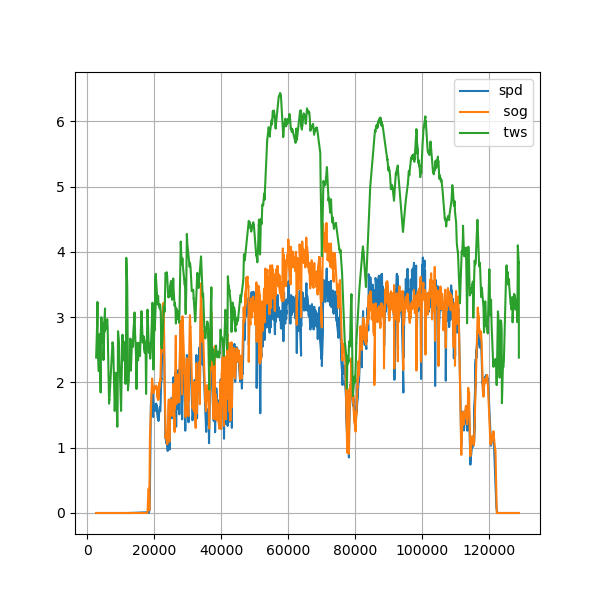

<IPython.core.display.Javascript object>


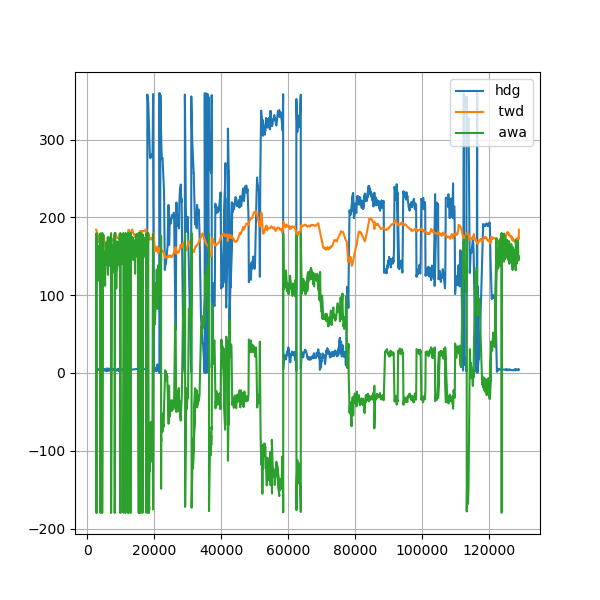

In [15]:
# notebook - plot using conventional tools

plt.figure()
df.spd.plot()
df.sog.plot()
df.tws.plot()
plt.grid()
plt.legend("spd, sog, tws".split(','), loc="upper right")

plt.figure()
df.hdg.plot()
df.twd.plot()
df.awa.plot()
plt.grid()
plt.legend("hdg, twd, awa".split(','), loc="upper right")

### Improving and streamlining plotting

The plan:

- Create a quick one liner to plot instrument data with legends, etc.
- Enable linking of plots, to examine instruments of varying types.
- And finally, link this to the chart.
  - Show only the portion of the track associated with the plot.
  - A single click on the graph plots a marker on the track, to associate a point in time with a point in space.

In [16]:

def quick_plot(index, data, legend=None, fignum=None, clf=True, title=None, s=slice(None, None, None), ylim=None):
    """
    Super quick tool to display multiple plots on a single axis.

    All data is assumed to share a single index (X axis).  All data is the same length.

    INDEX, which can be None, is the common index for all plots.
    DATA is a sequence of multiple Y axis data (e.g. list or numpy array)
         NOTE: data can be string.  If so it is assumed that it is a comma separated list of
         expressions (see example below).
    LEGEND is a list of legend names one for each data
    FIGNUM is the existing figure to use.
    CLF to clear before plotting, or just plot on what is already there
    YLIM to set the Y limits
    S an optional slice to limit the data to display (or reduce the size)

    For example: 

    quick_plot(df.index, (df.one, df.two, df.three), ['one', 'two', 'three'])
    quick_plot(df.index, (df.one, df.two, df.three), "df.one df.two df.three")
    quick_plot(df.index, "df.one, df.two, df.three")  # Spiffy all in one!
    """
    # Setup the figure and axis
    if isinstance(fignum, matplotlib.figure.Figure):
        fig = fignum
    else:
        fig = plt.figure(num=fignum)
    if clf:
        fig.clf()
    # Create a single axis that fills the figure
    ax = fig.add_subplot(111)
    # Do the plotting
    plot = quick_plot_ax(ax, index, data, legend=legend, s=s)
    # Decorate or adjust
    if ylim is not None:
        ax.set_ylim(*ylim)
    if title is not None:
        fig.suptitle(title, fontsize=14, fontweight='bold')
    fig.tight_layout()
    return plot

def find_nearest(array, value):
    "Find nearest value in array."
    idx = np.searchsorted(array, value, side="left")
    return idx, array[idx]

def to_local_timezone(dt):
    "Convert a datetime to a local datetime."
    HERE = tz.tzlocal()
    UTC = tz.gettz('UTC')
    gmt = dt.replace(tzinfo=UTC)
    return gmt.astimezone(HERE)

# I found that plotting data against a datetime was very slow.  One solution is to explicitly
# compute the datetime ticks.

def get_ticks(datetimes):
    "Explicitly compute the ticks for an array of datetimes."
    formatter = matplotlib.dates.DateFormatter('%H:%M', tz=G.TIMEZONE)
    # Pick a delta time that yields a reasonable number of ticks.
    for dt in [120, 90, 60, 30, 20, 10, 8, 6, 4, 2, 1]:
        loc = matplotlib.dates.MinuteLocator(byminute=None, interval=dt, tz=G.TIMEZONE)
        tick_values = loc.tick_values(datetimes.iloc[0], datetimes.iloc[-1])
        G.logger.debug(f"dt = {dt}, {str(tick_values)}")
        if len(tick_values) > 8:
            break
    tick_datetimes = [to_local_timezone(matplotlib.dates.num2date(v)) for v in tick_values]
    tick_positions = [find_nearest(datetimes, v)[0] for v in tick_datetimes]
    tick_labels = [formatter.format_data(v) for v in tick_values]
    return tick_positions, tick_labels

def quick_plot_ax(ax, index, data, legend=None, s=slice(None, None, None)):
    "Helper function.  See quick_plot for documentation of arguments."
    if isinstance(data, str):
        expressions = data.split(',')
        data = []
        for d in expressions:
            G.logger.debug(f"Evaluating expression {d}")
            data.append(eval(d))
        if legend is None:
            legend = expressions
    np_data = [np.asarray(d) for d in data]
    x = range(len(np_data[0][s]))
    
    def draw():
        if index is None:
            x = range(len(np_data[0][s]))
        else:
            x = index[s]
        if is_datetime(index):
            # If a datetime this can be slow.  Use a range instead, which is fast, and explicitly
            # compute the ticks.
            x = range(len(np_data[0][s]))
            tick_positions, tick_labels = get_ticks(index[s])
            ax.set_xticks(tick_positions) 
            ax.set_xticklabels(tick_labels)
        for d in np_data:
            ax.plot(x, d[s])
        if isinstance(legend, str):
            # When the loc is 'best' then it is very slow!
            ax.legend(legend.split(','), loc='upper right')
        elif is_iterable(legend):
            ax.legend(legend, loc='upper right')
        ax.grid(True)

    def update_func(begin, end):
        nonlocal s
        s = slice(begin, end)
        ax.clear()
        draw()

    def trim_func(*args):
        pass

    draw()

    return DictClass(trim_func=trim_func, update_func=update_func)


def is_datetime(series_like):
    "Does this series contain data which looks like a?"
    # The column types are weirdly obscure. Check the first value.
    np_datetime = isinstance(nth_value(series_like, 0), np.datetime64)
    pd_datetime = isinstance(nth_value(series_like, 0), pd.Timestamp)
    return np_datetime or pd_datetime

def nth_value(series_like, n):
    if isinstance(series_like, pd.Series):
        return series_like.iloc[n]
    elif isinstance(series_like, np.ndarray):
        return series_like[n]

<IPython.core.display.Javascript object>


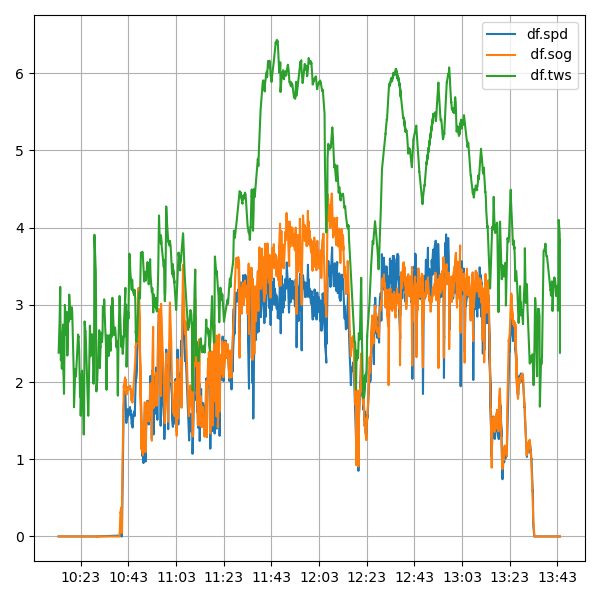

2021-02-21 20:43:24,407|DEBUG|quick_plot_ax| Evaluating expression df.spd
2021-02-21 20:43:24,408|DEBUG|quick_plot_ax| Evaluating expression  df.sog
2021-02-21 20:43:24,408|DEBUG|quick_plot_ax| Evaluating expression  df.tws
2021-02-21 20:43:24,411|DEBUG|get_ticks| dt = 120, [18216.77986111 18216.86319444]
2021-02-21 20:43:24,413|DEBUG|get_ticks| dt = 90, [18216.80069444 18216.86319444]
2021-02-21 20:43:24,414|DEBUG|get_ticks| dt = 60, [18216.77986111 18216.82152778 18216.86319444 18216.90486111]
2021-02-21 20:43:24,416|DEBUG|get_ticks| dt = 30, [18216.77986111 18216.80069444 18216.82152778 18216.84236111
 18216.86319444 18216.88402778 18216.90486111]
2021-02-21 20:43:24,418|DEBUG|get_ticks| dt = 20, [18216.76597222 18216.77986111 18216.79375    18216.80763889
 18216.82152778 18216.83541667 18216.84930556 18216.86319444
 18216.87708333 18216.89097222 18216.90486111]


{'trim_func': <function __main__.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function __main__.quick_plot_ax.<locals>.update_func(begin, end)>}

In [17]:
# notebook 

# Simple single graph.  
quick_plot(df.row_times, "df.spd, df.sog, df.tws")

<IPython.core.display.Javascript object>


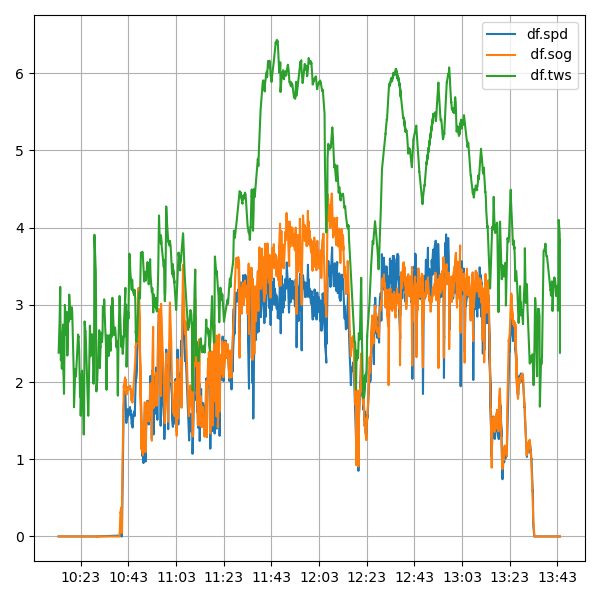

2021-02-21 20:43:24,580|DEBUG|quick_plot_ax| Evaluating expression df.spd
2021-02-21 20:43:24,580|DEBUG|quick_plot_ax| Evaluating expression  df.sog
2021-02-21 20:43:24,581|DEBUG|quick_plot_ax| Evaluating expression  df.tws
2021-02-21 20:43:24,583|DEBUG|get_ticks| dt = 120, [18216.77986111 18216.86319444]
2021-02-21 20:43:24,584|DEBUG|get_ticks| dt = 90, [18216.80069444 18216.86319444]
2021-02-21 20:43:24,586|DEBUG|get_ticks| dt = 60, [18216.77986111 18216.82152778 18216.86319444 18216.90486111]
2021-02-21 20:43:24,588|DEBUG|get_ticks| dt = 30, [18216.77986111 18216.80069444 18216.82152778 18216.84236111
 18216.86319444 18216.88402778 18216.90486111]
2021-02-21 20:43:24,589|DEBUG|get_ticks| dt = 20, [18216.76597222 18216.77986111 18216.79375    18216.80763889
 18216.82152778 18216.83541667 18216.84930556 18216.86319444
 18216.87708333 18216.89097222 18216.90486111]


{'trim_func': <function __main__.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function __main__.quick_plot_ax.<locals>.update_func(begin, end)>}

In [18]:
# notebook 

# Simple single graph.  
quick_plot(df.row_times, "df.spd, df.sog, df.tws")

In [19]:
# notebook 

# Compute a version of VMG (velocity made good)
thdg = df.hdg + df.variation.mean()  # Get the boats heading in true north
angle = np.radians(df.twd - thdg)    # Angle to the true wind
vmg = np.abs(np.cos(angle)) * df.spd         # Speed in the direction of true wind.

# Pair of linked graphs.
fig = plt.figure(figsize=(8, 12))  # make this figure large
ax1 = plt.subplot(211)             # Create two axes.
ax2 = plt.subplot(212, sharex=ax1) # Link the x-axis of the axes.
# Plot on each axis
pl = quick_plot_ax(ax1, None, "df.spd, df.sog, df.tws, vmg")
pl = quick_plot_ax(ax2, None, "df.hdg, df.twd, 100+5*df.rudder, df.awa")
fig.tight_layout()

In [21]:
# To link plot to the chart, we add two functions to the chart.  
#
# 1. to trim the track shown to match the plot.
# 2. to show a point at a particular time

def chart_update_functions(chart, skip=None):
    """
    Create two update functions.
    
    trim_func(begin, end) redraws the track trimming off the points before begin and after
    end.

    point_func(time) draws mark at the particular time along the track
    """

    # There can be a huge number of sampled points (at 10Hz).  This limits the total
    # number of samples.
    if skip is None:
        skip = math.ceil(len(chart.track) / 8000)  # No more than 2000 points
    track = chart.track[::skip]

    def trim_func(begin, end):
        G.logger.info(f"trim_func {track.shape} {begin} {end}")
        begin = max(0, begin)
        # end = min(track.shape[0])
        G.logger.info(f"trim_func {begin} {end}")        
        chart.begin, chart.end = begin, end
        b, e = int(begin/skip), int(end/skip)
        chart.line.set_data(track[b:e, 0],
                            track[b:e, 1])
        chart.fig.canvas.draw_idle()

    chart.point = None

    def point_func(time):
        point = chart.track[time]
        G.logger.info(f"Calling point_func update with {time}, {point}")
        if chart.point is None:
            chart.point = chart.ax.plot([point[0]], [point[1]], linestyle = 'None', marker='+', color='red')[0]
        else:
            chart.point.set_data([point[0]], [point[1]])
        chart.fig.canvas.draw_idle()

    chart.trim_func = trim_func
    chart.point_func = point_func

    return chart


In [38]:
# And now we pull it all together.

def chart_and_plot(df, index, data, data2=None):
    """
    Create a figure with one or two plots of data, along with a synced chart/track.

    - If you zoom/pan the top plot, then the track will display the region of interest.
    - If you click on either plot, then the point on the chart will be highlighted.
    """
    if data2 is not None:
        # Create three axes.
        fig = plt.figure(figsize=(8, 10))  # make this figure large
        ax1 = plt.subplot(311)
        ax2 = plt.subplot(312, sharex=ax1)
        ax_chart = plt.subplot(313)
    else:
        # Create two axes.
        fig = plt.figure(figsize=(8, 8))  # make this figure large
        ax1 = plt.subplot(211)
        ax_chart = plt.subplot(212)
        
    quick_plot_ax(ax1, index, data)
    if data2 is not None:
        quick_plot_ax(ax2, index, data2)

    # Chart in the third axis.
    region = extract_region(df) 
    chart = create_chart(region)    
    chart.fig = fig
    chart.ax = ax_chart        # Assign the axis
    chart = draw_chart(chart)
    chart = draw_track(df, chart, color='chartreuse')  # Draw track in light color
    chart = draw_track(df, chart, color='green')       # Draw again in darker
    # Note, chart.line and other attributes are overridden, purposefully.
    fig.tight_layout()

    # Create a set of chart update functions, 
    chart = chart_update_functions(chart)

    # Arrange it so that the plots match the chart, by redrawing the chart to highlight
    # the currently zoomed region in the plots, stored in xlim

    # Declare and register callbacks
    def on_xlim_change(event_ax):
        G.logger.info(f"xlim changed")
        lo, hi = [int(v) for v in ax1.get_xlim()]
        G.logger.info(f"updated xlim: {(lo, hi)}")
        print(lo, hi)
        chart.trim_func(lo, hi)

    ax1.callbacks.connect('xlim_changed', on_xlim_change)
    # if (data2 is not None):
    #    ax2.callbacks.connect('xlim_changed', on_xlim_change)

    def on_click(event):
        G.logger.info(f"Click event: {event.xdata}")
        if event.xdata is not None:
            chart.point_func(int(event.xdata))

    fig.canvas.mpl_connect('button_press_event', on_click)
    return chart


<IPython.core.display.Javascript object>


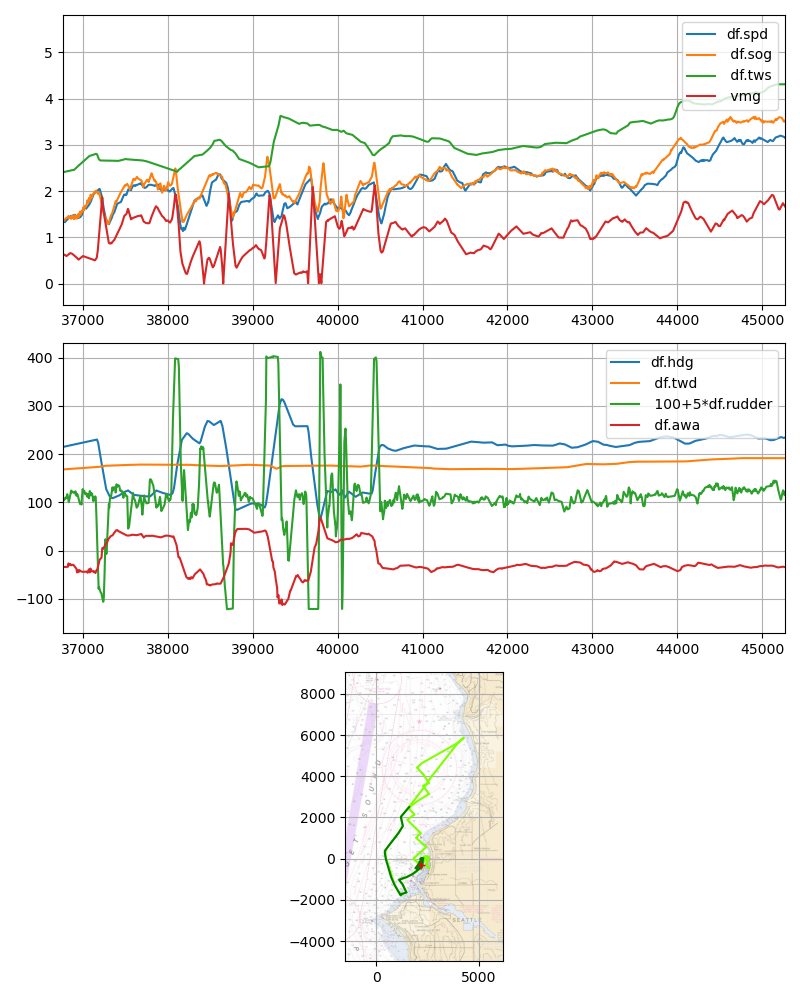

2021-02-21 21:27:09,356|DEBUG|quick_plot_ax| Evaluating expression df.spd
2021-02-21 21:27:09,357|DEBUG|quick_plot_ax| Evaluating expression  df.sog
2021-02-21 21:27:09,357|DEBUG|quick_plot_ax| Evaluating expression  df.tws
2021-02-21 21:27:09,358|DEBUG|quick_plot_ax| Evaluating expression  vmg
2021-02-21 21:27:09,430|DEBUG|quick_plot_ax| Evaluating expression df.hdg
2021-02-21 21:27:09,431|DEBUG|quick_plot_ax| Evaluating expression  df.twd
2021-02-21 21:27:09,431|DEBUG|quick_plot_ax| Evaluating expression  100+5*df.rudder
2021-02-21 21:27:09,432|DEBUG|quick_plot_ax| Evaluating expression  df.awa
2021-02-21 21:27:09,505|DEBUG|run_system_command| Running command: rm /tmp/mbtile.tif
2021-02-21 21:27:09,512|DEBUG|run_system_command| Command finished in 0.006 seconds.
2021-02-21 21:27:09,512|DEBUG|run_system_command| Running command: gdalwarp  -te -122.4586422 47.6425354 -122.3565711 47.7689130  -te_srs EPSG:4326  -t_srs ' +proj=tmerc +lat_0=47.6873070 +lon_0=-122.4386440 +k_0=0.9996 +datu

In [39]:
# notebook

ch = chart_and_plot(df, None, "df.spd, df.sog, df.tws, vmg", "df.hdg, df.twd, 100+5*df.rudder, df.awa")

In [33]:
ch.trim_func(10000, 50000)

2021-02-21 21:22:41,777|INFO|trim_func| trim_func (7887, 2) 10000 50000
2021-02-21 21:22:41,778|INFO|trim_func| trim_func 10000 50000


In [24]:
# One of the critical tasks is to trim the data to remove time at the dock, or to slip into races.

def trim_track(df, fig_or_num=None, border=0.2, skip=None, delay=0.01):
    """
    Plot an interactive sail track on a map.  Provides sliders which can be used to trim
    the begin and end of the track.

    One potential use is to find the trim points so that only the race is
    displayed/analyzed.

    ch = plot_track(df)
    # Play with the UI, this happens in a different thread
    # At any point you can get the values of the sliders.
    print(ch.begin, ch.end)
    
    """
    # Chart in the third axis.
    region = extract_region(df) 
    chart = create_chart(region)
    chart.fig, chart.ax = create_figure(fig_or_num)

    chart = draw_chart(chart)  
    chart = draw_track(df, chart, color='chartreuse')  # Draw track in light color
    chart = draw_track(df, chart, color='green')       # Draw again in darker   

    # Chart overlapps the widgets... sometimes.
    # chart.fig.tight_layout()

    # Create a set of chart update functions, 
    chart = chart_update_functions(chart)

    ax_beg = chart.fig.add_axes([0.05, 0.1, 0.03, 0.8], facecolor='lightgoldenrodyellow')
    ax_end = chart.fig.add_axes([0.11, 0.1, 0.03, 0.8], facecolor='lightgoldenrodyellow')
    count = chart.track.shape[0]
    chart.begin, chart.end = 0, count-1
    s_beg = widgets.Slider(ax_beg, 'Begin', 0, count, valinit=0, orientation='vertical', valfmt="%i")
    s_end = widgets.Slider(ax_end, 'End',   0, count-1, valinit=count-1, orientation='vertical', valfmt="%i")

    # Unfortunate "bug" that graph can be unresponsive if you do not keep a handle on the sliders.
    # https://github.com/matplotlib/matplotlib/issues/3105/
    chart.sliders = [s_beg, s_end]
    chart.is_trimmed = False
    chart = chart_update_functions(chart)

    def trim(val):
        G.logger.info(f"Calling plot_track update.")
        chart.is_trimmed = True
        chart.trim_func(int(s_beg.val), int(s_end.val))
        chart.fig.canvas.draw_idle()

    s_beg.on_changed(trim)
    s_end.on_changed(trim)

    return chart


2021-02-21 20:43:25,939|DEBUG|run_system_command| Running command: rm /tmp/mbtile.tif
2021-02-21 20:43:25,947|DEBUG|run_system_command| Command finished in 0.006 seconds.
2021-02-21 20:43:25,947|DEBUG|run_system_command| Running command: gdalwarp  -te -122.4586422 47.6425354 -122.3565711 47.7689130  -te_srs EPSG:4326  -t_srs ' +proj=tmerc +lat_0=47.6873070 +lon_0=-122.4386440 +k_0=0.9996 +datum=WGS84 +units=m +no_defs ' -ts 0 2000 -r bilinear Data/MBTILES/MBTILES_06.mbtiles /tmp/mbtile.tif
2021-02-21 20:43:26,345|DEBUG|run_system_command| Command finished in 0.397 seconds.
2021-02-21 20:43:26,410|DEBUG|create_figure| Creating figure None


<IPython.core.display.Javascript object>


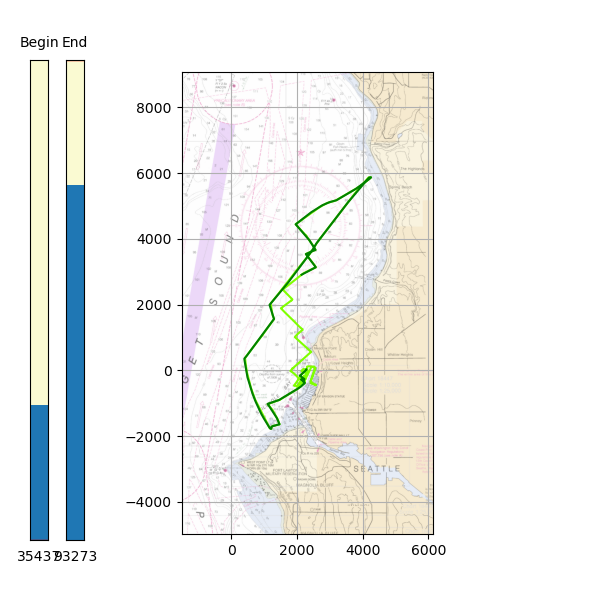

In [25]:
# notebook 

ch = trim_track(df)

In [26]:
# notebook

# The trimming process runs asynchronously and in the background. When you're done, you can access the 
# result through the attributes begin and end

start_time = df.iloc[ch.begin].row_times
end_time = df.iloc[ch.end].row_times

display_markdown(f"Trimmed track starts at {start_time}.")
display_markdown(f"Trimmed track starts at {end_time}.")


Trimmed track starts at 2019-11-16 10:13:43.020000-08:00.

Trimmed track starts at 2019-11-16 13:44:02.359048482-08:00.

# Appendix - NOAA tiles

This appendix includes some example code to pull tiles from the NOAA tile server and then combine them into a map. This code should work for any region where NOAA has charts.  And likley a small modification would work for other tile servers (since this format is relatively standard).

In [27]:
# notebook - Returning to tiles.  

# This code is here for completeness.  It is not part of the module.  It can be substituted 
# for the offline code above if needed.
#
# The tiles are not geolocated in the same fashion as above.  Though this is not too hard.

# For requesting tiles from the NOAA servers
import requests
import PIL
import io
import concurrent.futures

TILE_SIZE = 256

def fetch_noaa_chart(df, zoom=14, border=0.2):
    # Add/sub just a bit to make the map interpretable for small excursions
    start = time.perf_counter()
    region = extract_region(df, border)    
    
    x_min, y_max = deg2num(region.lat_min, region.lon_min, zoom)  # South West corner
    x_max, y_min = deg2num(region.lat_max, region.lon_max, zoom)  # North East corner
    
    # Add one to ensure we get the boundaries
    x_max += 1
    y_max += 1
    
    addresses = list(it.product(range(x_min, x_max), range(y_min, y_max), [zoom]))

    G.logger.info(f"About to fetch {len(addresses)} tiles.")

    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as ex:
        addressed_tiles = list(ex.map(fetch_noaa_tile, addresses))
    
    cols = x_max - x_min
    rows = y_max - y_min
    res = np.zeros((rows * TILE_SIZE, cols * TILE_SIZE, 3), dtype=np.uint8)

    for (x, y, zoom), tile in addressed_tiles:
        coffset = (x - x_min) * TILE_SIZE
        roffset = (y - y_min) * TILE_SIZE
        G.logger.debug(f"{roffset}, {coffset}")
        res[roffset:(roffset+TILE_SIZE), coffset:(coffset+TILE_SIZE), :] = tile

    end = time.perf_counter()
    G.logger.info(f"Finished in {end-start:.3f} seconds.")
    return res

def fetch_noaa_tile(address):
    G.logger.debug(f"Fetching tile: {address}")
    x, y, zoom = address
    r = requests.get(noaa_url(x, y, zoom))
    tile = PIL.Image.open(io.BytesIO(r.content))
    if tile.mode != 'RGB':
        np_tile = np.asarray(tile.convert(mode="RGB"))
    else:
        np_tile = np.asarray(tile)
    G.logger.debug(f"Done fetching tile: {address}")
    return address, np_tile
    
def noaa_url(x, y, zoom):
    return f"https://tileservice.charts.noaa.gov/tiles/50000_1/{zoom}/{x}/{y}.png"    

def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    # This returns the NW-corner of the square. Use the function with xtile+1 and/or
    # ytile+1 to get the other corners. With xtile+0.5 & ytile+0.5 it will return the
    # center of the tile.
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)




2021-02-21 20:43:26,759|INFO|fetch_noaa_chart| About to fetch 60 tiles.
2021-02-21 20:43:26,761|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5710, 14)
2021-02-21 20:43:26,761|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5711, 14)
2021-02-21 20:43:26,761|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5712, 14)
2021-02-21 20:43:26,761|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5713, 14)
2021-02-21 20:43:26,762|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5714, 14)
2021-02-21 20:43:26,762|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5715, 14)
2021-02-21 20:43:26,763|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5716, 14)
2021-02-21 20:43:26,763|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5717, 14)
2021-02-21 20:43:26,763|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5718, 14)
2021-02-21 20:43:26,764|DEBUG|fetch_noaa_tile| Fetching tile: (2618, 5719, 14)
2021-02-21 20:43:27,235|DEBUG|fetch_noaa_tile| Done fetching tile: (2618, 5715, 14)
2021-02-21 20:43:27,235|DEBUG|fetch_noaa_tile| Fetchin

2021-02-21 20:43:29,849|DEBUG|fetch_noaa_tile| Done fetching tile: (2623, 5710, 14)
2021-02-21 20:43:29,850|DEBUG|fetch_noaa_tile| Fetching tile: (2623, 5715, 14)
2021-02-21 20:43:29,873|DEBUG|fetch_noaa_tile| Done fetching tile: (2622, 5718, 14)
2021-02-21 20:43:29,874|DEBUG|fetch_noaa_tile| Fetching tile: (2623, 5716, 14)
2021-02-21 20:43:29,904|DEBUG|fetch_noaa_tile| Done fetching tile: (2622, 5719, 14)
2021-02-21 20:43:29,904|DEBUG|fetch_noaa_tile| Fetching tile: (2623, 5717, 14)
2021-02-21 20:43:29,947|DEBUG|fetch_noaa_tile| Done fetching tile: (2623, 5711, 14)
2021-02-21 20:43:29,948|DEBUG|fetch_noaa_tile| Fetching tile: (2623, 5718, 14)
2021-02-21 20:43:29,996|DEBUG|fetch_noaa_tile| Done fetching tile: (2623, 5712, 14)
2021-02-21 20:43:29,997|DEBUG|fetch_noaa_tile| Fetching tile: (2623, 5719, 14)
2021-02-21 20:43:30,064|DEBUG|fetch_noaa_tile| Done fetching tile: (2623, 5713, 14)
2021-02-21 20:43:30,163|DEBUG|fetch_noaa_tile| Done fetching tile: (2623, 5714, 14)
2021-02-21 20:43:

<IPython.core.display.Javascript object>


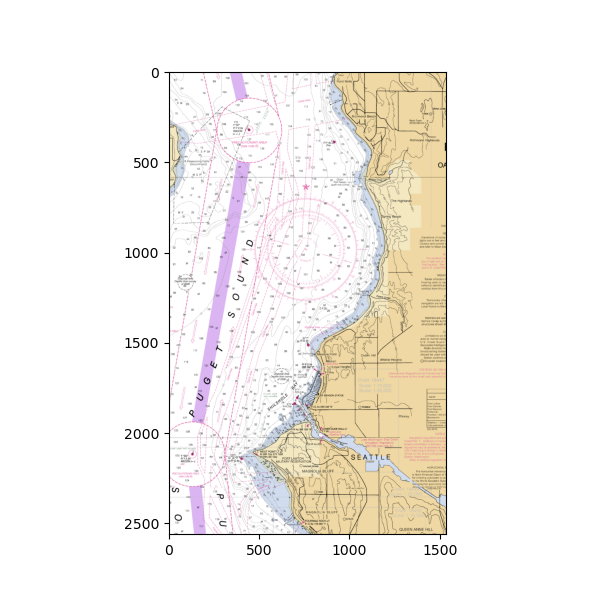

In [28]:
#notebook 

image = fetch_noaa_chart(df, zoom=14)

fig, ax = new_axis()

# By specifying the extent, matplot "knows" the scale of the image.  Note, extent is
# weird: (left, right, bottom, top) Let's set the image coordinates to start 0,0 at the
# lower left.
ax.imshow(image)

In [29]:
# notebook - This is here for historical reference...  we do not use basemaps anymore.

#
# This "function" includes calls to gdal_translate and gdaladdo, with a bit of documentation.
#
# Note it no longer works.

def gdal_basemap(chart, source_path, chart_path, zoom_level=None):
    
    # Interesting part of this is that gdalwarp is used to generate a VRT file, and not
    # the final image.  VRT is a language for specifying remaps.  No actual work is done.
    zoom = "-oo ZOOM_LEVEL=16"
    zoom = ""
    command = "gdalwarp"
    command += " " + zoom
    command += " " + t_srs_arg
    command += " " + te_arg
    command += " " + f"-te_srs EPSG:4326 -ts {map_width} 0 -r bilinear"
    command += " " + "-of vrt"
    command += f" {G.MBTILES_PATH} /tmp/chart.vrt"

    # The VRT file is read and executed by gdal_translate.  Why?  gdal_translate can
    # produce compressed and tiled output.  And generally seems move powerful.
    #
    # The gdal_translate utility can be used to convert raster data between different
    # formats, potentially performing some operations like subsettings, resampling, and
    # rescaling pixels in the process.

    command = "gdal_translate"
    command += " -co COMPRESS=JPEG -co TILED=YES"
    command += f" /tmp/chart.vrt {G.BASE_MAP_PATH}"

    # The gdaladdo utility can be used to build or rebuild overview images for most
    # supported file formats with one of several downsampling algorithms.
    
    command = "gdaladdo --config COMPRESS_OVERVIEW JPEG --config INTERLEAVE_OVERVIEW PIXEL"
    command += " -r average"
    command += f" {G.BASE_MAP_PATH}"
    command += " 2 4"


